# Importiere Daten


In [173]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os

## Funktionen definieren

In [174]:
def linear_reg(x, m, t):
    return m*x + t

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [175]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [176]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [177]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)

## Differenz berechnen

In [178]:
TMin_Lat = TMin.sel(lat = slice(50,66)).mean('lon')
TMax_Lat = TMax.sel(lat = slice(50,66)).mean('lon')
TAvg_Lat = TAvg.sel(lat = slice(50,66)).mean('lon')
time_values = TMax['time'].values
angles_in_degrees = TMin_Lat['lat']

# Convert degrees to radians (cos function in numpy works with radians)
angles_in_radians = np.radians(angles_in_degrees)
cosine_values = np.cos(angles_in_radians)
TMin_Lat.tmn
weight_fac = len(cosine_values)/np.sum(cosine_values)
# TMin_Lat_temp = TMin_Lat.tmn*cosine_values * weight_fac 
# TMax_Lat_temp = TMax_Lat.tmx*cosine_values * weight_fac
# TAvg_Lat_temp = TAvg_Lat.tmp*cosine_values * weight_fac

TMin_Lat_temp = TMin_Lat*cosine_values * weight_fac 
TMax_Lat_temp = TMax_Lat*cosine_values * weight_fac
TAvg_Lat_temp = TAvg_Lat*cosine_values * weight_fac
TMin_Lat_tot = TMin_Lat_temp.mean('lat')
TMax_Lat_tot = TMax_Lat_temp.mean('lat')
TAvg_Lat_tot = TAvg_Lat_temp.mean('lat')

In [179]:
# TMin_Lat = TMin.mean('lon')
# TMax_Lat = TMax.mean('lon')
# TAvg_Lat = TAvg.mean('lon')

In [180]:
time_values = TMax['time'].values

In [181]:
# TMin_Lat_tot = TMin_Lat.sel(lat = slice(40,70)).mean('lat')
# TMax_Lat_tot = TMax_Lat.sel(lat = slice(40,70)).mean('lat')
# TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(40,70)).mean('lat')

In [182]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [183]:
monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()
monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()


In [184]:
# daily_mean_DTR = temperature_difference_Pol.resample(time='D').mean()
# daily_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='D').mean()


# daily_mean_DTR['month'] = daily_mean_DTR['time'].dt.month
# daily_mean_TAvg['month'] = daily_mean_TAvg['time'].dt.month


In [185]:

monthly_mean_DTR['month'] = monthly_mean_DTR['time'].dt.month
monthly_mean_TAvg['month'] = monthly_mean_TAvg['time'].dt.month

c:\Users\leonh\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


## Generiere Unterteilungen des Nordpols (Ringe)

In [186]:
# Creating dict with different averages
TAvg_mean_dict = {}

slices = [(66, 70), (70, 75), (75, 80), (80, 84)]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = TAvg_Lat.tmp.sel(lat=slice(start, end)).mean('lat')
    TAvg_mean_dict[f'{start}-{end}'] = sliced_data

# Creating dict with different averages
DTR_mean_dict = {}

slices = [(66, 70), (70, 75), (75, 80), (80, 84)]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = temperature_difference_Lat.sel(lat=slice(start, end)).mean('lat')
    DTR_mean_dict[f'{start}-{end}'] = sliced_data


Plotten

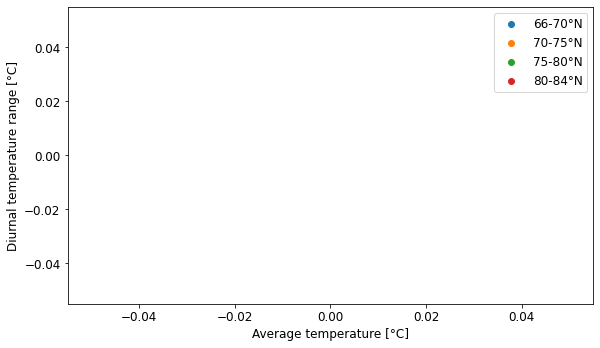

In [187]:
# Extract the keys and values from TAvg_mean_dict and DTR_mean_dict
ta_keys = list(TAvg_mean_dict.keys())

legend_handles = []

for i in ta_keys:
    plt.scatter(TAvg_mean_dict[i], DTR_mean_dict[i], label = i + '°N' )

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Average temperature [°C]')
plt.ylabel('Diurnal temperature range [°C]')


# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.png')
plt.legend()

plt.tight_layout()
plt.show()


## Plots Yearly trends

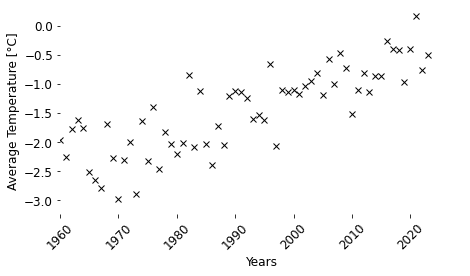

In [188]:
yearly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='Y').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Average Temperature [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Add gridlines
#ax.grid(True)

# Add a legend
#ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.xlim(pd.to_datetime('1960',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()



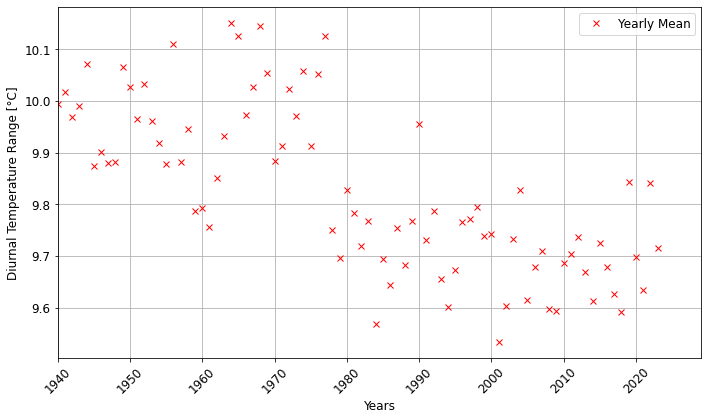

In [189]:
yearly_mean_DTR = temperature_difference_Pol.resample(time='Y').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Diurnal Temperature Range [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.xlim(pd.to_datetime('1940',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure

# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.png')
plt.show()



In [190]:
# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Yearly Mean')
# ax.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')
# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Temperature [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')
# # Remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # Add gridlines
# #ax.grid(True)

# # Add a legend
# #ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1960',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure
# plt.show()


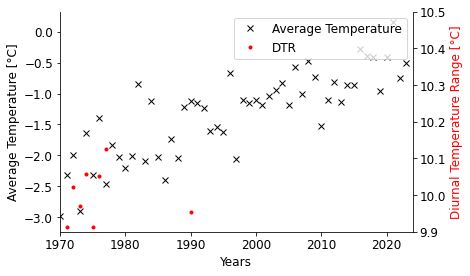

In [191]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# Plot the data with the first y-axis
ax1.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Average Temperature')
ax1.set_xlabel('Years')
ax1.set_ylabel('Average Temperature [°C]', color='black')

# Create a second y-axis and plot data with it
ax2 = ax1.twinx()
ax2.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='.', linestyle='',  color='red', label='DTR')
ax2.set_ylabel('Diurnal Temperature Range [°C]', color='r')


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

plt.xlim(pd.to_datetime('1970'),pd.to_datetime('2024'))
ax2.set_ylim(9.9, 10.5)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Show the plot
plt.tight_layout() 

#plt.savefig('AnnualDTR_TAvg_40_70.pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


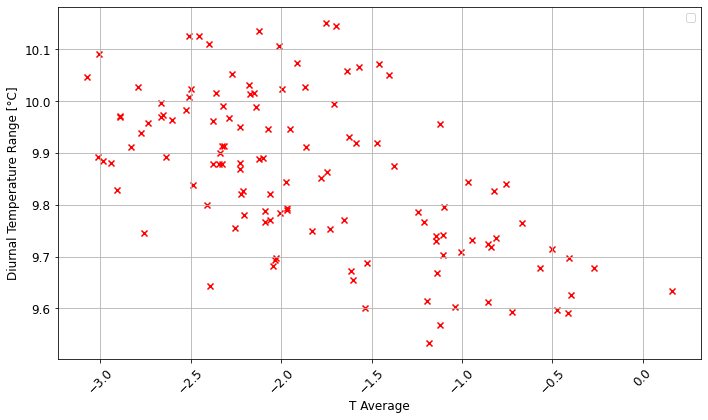

In [192]:
yearly_mean_DTR = temperature_difference_Pol.resample(time='Y').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.scatter(yearly_mean_TAvg, yearly_mean_DTR, marker='x',  color='r') #, label='Yearly Mean')

# Add labels and title
ax.set_xlabel('T Average')
ax.set_ylabel('Diurnal Temperature Range [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

#plt.xlim(pd.to_datetime('1940',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure

# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.png')
plt.show()



## Monthly trends

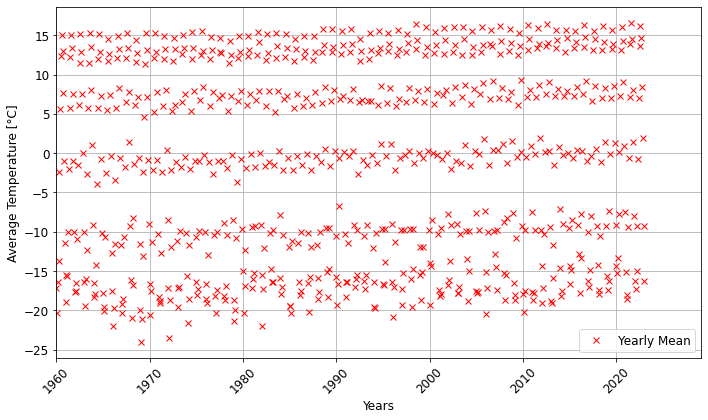

In [193]:
# monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(monthly_mean_TAvg.time, monthly_mean_TAvg, marker='x', linestyle='',  color='r', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Average Temperature [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.xlim(pd.to_datetime('1960',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()



<xarray.DataArray (time: 1464)>
array([ 8.98117082, 10.40682718, 11.49653281, ...,  7.84525065,
        6.93935845,  7.54031954])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1901-02-28 ... 2022-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


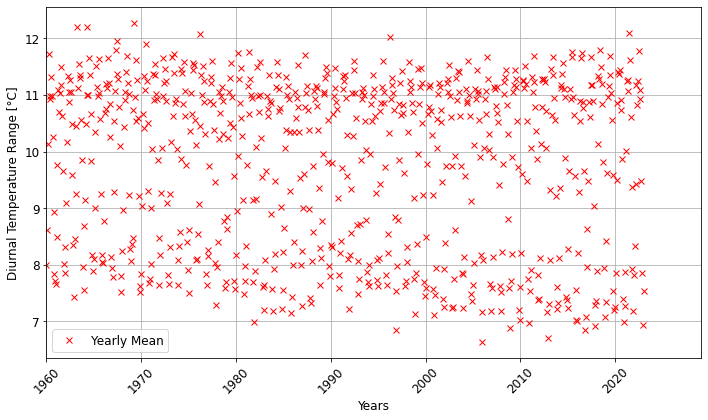

In [194]:
# monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()

print(monthly_mean_DTR)
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Plot the data with a line style and add labels
ax.plot(monthly_mean_DTR.time, monthly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')

# Add labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Diurnal Temperature Range [°C]')
#ax.set_title('Diurnal Temperature Range Over Time')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.xlim(pd.to_datetime('1960',))
# Show the plot
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()



In [195]:
monthly_mean_DTR

<xarray.DataArray (time: 1464)>
array([ 8.98117082, 10.40682718, 11.49653281, ...,  7.84525065,
        6.93935845,  7.54031954])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1901-02-28 ... 2022-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [196]:
monthly_mean_DTR_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = monthly_mean_DTR.where(monthly_mean_DTR['month'] == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_DTR_dict[i] = month_data

monthly_mean_TAvg_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = monthly_mean_TAvg.where(monthly_mean_TAvg['month'] == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TAvg_dict[i] = month_data

monthly_mean_TMin_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = TMin_Lat_tot.tmn.where(TMin_Lat_tot['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TMin_dict[i] = month_data

monthly_mean_TMax_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = TMax_Lat_tot.tmx.where(TMax_Lat_tot['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TMax_dict[i] = month_data

c:\Users\leonh\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
c:\Users\leonh\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
c:\Users\leonh\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
c:\Users\leonh\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a fut

In [197]:
monthly_mean_TMin_dict

{1: <xarray.DataArray 'tmn' (time: 122)>
 array([-25.08600016, -24.10822695, -24.02304401, -24.41607358,
        -23.59200886, -25.43927868, -27.27319045, -25.26203909,
        -26.48400416, -24.24129801, -25.93331856, -24.80429817,
        -25.51428151, -23.23166294, -25.04433475, -24.45768082,
        -25.74428744, -23.42683885, -25.55134579, -24.15923156,
        -23.03792382, -25.77346946, -24.28719403, -25.36160329,
        -22.39909954, -22.14820923, -25.23143973, -23.44681213,
        -26.11228332, -23.39725939, -24.75134327, -21.18900551,
        -26.32656717, -22.95578199, -25.28716937, -24.60429471,
        -24.42056034, -23.77191632, -24.10266963, -26.30703043,
        -25.74327347, -24.28319442, -25.51623959, -20.88954183,
        -24.24945307, -23.45742512, -26.18338003, -22.13850594,
        -21.20752721, -28.01959282, -25.77596344, -24.2409285 ,
        -24.59116264, -27.09847018, -21.74112728, -24.50982262,
        -24.07239809, -22.41192688, -23.61055324, -24.61223305,

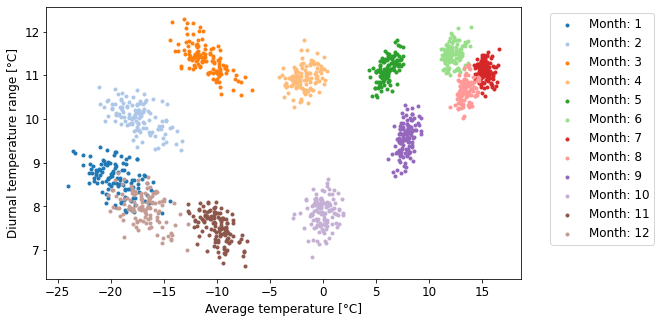

In [198]:


# Create an empty list to store legend handles for custom legend
legend_handles = []

for i in range(1, 13):
    color = legend_colors[i - 1]
    plt.scatter(monthly_mean_TAvg_dict[i], monthly_mean_DTR_dict[i], marker='.', color=color, label='Month: ' + str(i))
    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# Plot legend outside the plot
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Average temperature [°C]')
plt.ylabel('Diurnal temperature range [°C]')


# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.png')

plt.show()



In [199]:
monthly_mean_TAvg = monthly_mean_TAvg.rename('TAvg')

monthly_mean_DTR = monthly_mean_DTR.rename('DTR')
df_merged = xr.merge([monthly_mean_DTR, monthly_mean_TAvg])


In [200]:
# d = 0.5  # Adjust this value to your desired interval length

# # Create bins for the 'x' values
# df_merged['bin'] = (df_merged['TAvg'] // d) * d

# # Calculate the means of 'y' values in each bin
# means_df = df_merged.groupby('bin')['DTR'].mean().reset_index()

# # Rename the columns for clarity
# means_df.columns = ['TAvg_bin', 'DTR']

# # Drop the 'bin' column if you don't need it
# #means_df = means_df.drop(columns='bin')

# # Print or use means_df as needed
# plt.plot(means_df['TAvg_bin'], means_df['DTR'], marker = 'x', ls = '', color = 'red')


# Assuming monthly_mean_DTR and monthly_mean_TAvg are your DataArrays
# Rename the DataArrays to have explicit names


In [201]:
monthly_mean_TAvg = monthly_mean_TAvg.rename('TAvg')
monthly_mean_DTR = monthly_mean_DTR.rename('DTR')


# Merge the DataArrays into a Dataset
df_merged = xr.merge([monthly_mean_DTR, monthly_mean_TAvg])
df_merged['DTR']

<xarray.DataArray 'DTR' (time: 1464)>
array([ 8.98117082, 10.40682718, 11.49653281, ...,  7.84525065,
        6.93935845,  7.54031954])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1901-02-28 ... 2022-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [202]:
# daily_mean_TAvg = daily_mean_TAvg.rename('TAvg [°C]')
# daily_mean_DTR = daily_mean_DTR.rename('DTR [°C]')


# # Merge the DataArrays into a Dataset
# df_days = xr.merge([daily_mean_TAvg, daily_mean_DTR])
# df_days['DTR [°C]']

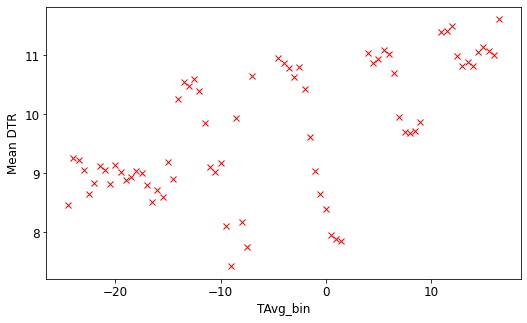

In [203]:

# print(df_merged.data_vars)

# # Adjust this value to your desired interval length
# d = 0.5

# # Create bins for the 'TAvg' values
# df_merged['bin'] = np.floor(df_merged['TAvg'] / d) * d

# # Calculate the means of 'DTR' values in each bin
# means_df = df_merged.groupby('bin').agg({'DTR': 'mean'}).reset_index()

# # Rename the columns for clarity
# means_df.columns = ['TAvg_bin', 'Mean DTR']

# # Plot the results
# plt.plot(means_df['TAvg_bin'], means_df['Mean DTR'], marker='x', ls='', color='red')
# plt.xlabel('TAvg')
# plt.ylabel('Mean DTR')
# plt.show()

# Adjust this value to your desired interval length
d = 0.5

# Create bins for the 'TAvg' values
df_merged['bin'] = (np.floor(df_merged['TAvg'] / d) * d).astype(np.float32)

# Calculate the mean of 'DTR' values in each bin
means_da = df_merged.groupby('bin').mean(dim='time')['DTR']

# Plot the results
means_da.plot(marker='x', linestyle='', color='red')
plt.xlabel('TAvg_bin')
plt.ylabel('Mean DTR')
plt.show()

In [204]:
# Create bins for the 'TAvg' values
df_merged['bin'] = np.floor(df_merged['TAvg'] / d) * d
# Calculate the means of 'DTR' values in each bin
means_df = df_merged.groupby('bin').mean(dim='time')

## Monthly Trends with Fit

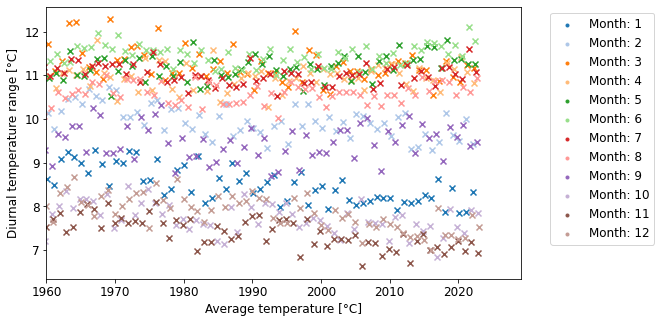

In [205]:
legend_colors = [plt.cm.tab20(i) for i in np.linspace(0, 1, 12)]
legend_colors = plt.cm.tab20(range(12))

# Create an empty list to store legend handles for custom legend
legend_handles = []

for i in range(1, 13):
    color = legend_colors[i - 1]
    plt.scatter(monthly_mean_DTR_dict[i]['time'], monthly_mean_DTR_dict[i], marker='x', color=color, label='Month: ' + str(i))
    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# Plot legend outside the plot
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Average temperature [°C]')
plt.ylabel('Diurnal temperature range [°C]')

plt.xlim(pd.to_datetime('1960',))

# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.pdf')
# plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.png')

plt.show()




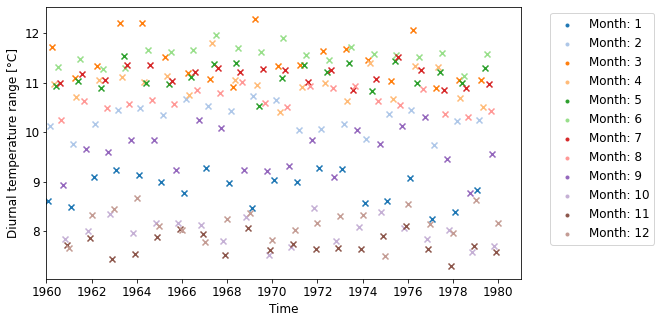

In [206]:


# Create a list of legend colors
legend_colors = plt.cm.tab20(range(12))

# Create an empty list to store legend handles for custom legend
legend_handles = []

for i in range(1, 13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_DTR_dict[i]['time'] >= pd.to_datetime('1960-01-01')) & (monthly_mean_DTR_dict[i]['time'] <= pd.to_datetime('1980-01-01'))
    plt.scatter(monthly_mean_DTR_dict[i]['time'][mask], monthly_mean_DTR_dict[i][mask], marker='x', color=color, label='Month: ' + str(i))
    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# Plot legend outside the plot
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Time')
plt.ylabel('Diurnal temperature range [°C]')

# Set x-axis limits to the specified date range
plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('1980-12-31'))

plt.show()


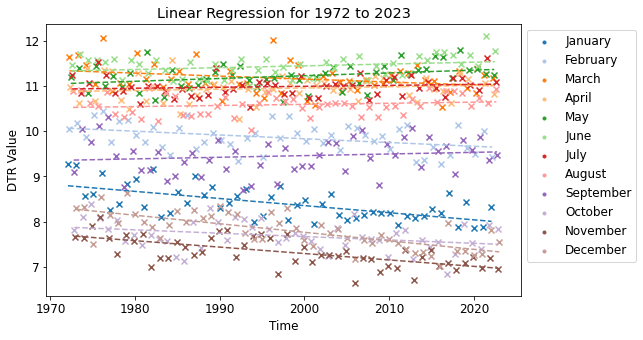

C:\Users\leonh\AppData\Local\Temp\ipykernel_5592\1695896888.py:76: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r*-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')


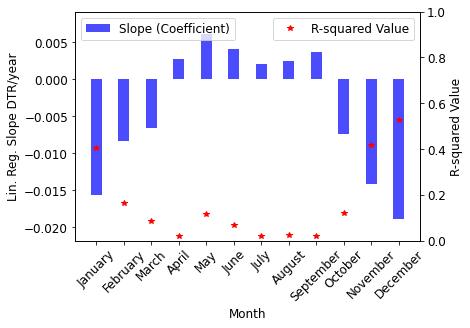

In [207]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 

for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)
    
    x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_DTR_dict[i][mask]

    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    plt.scatter(monthly_mean_DTR_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    plt.plot(monthly_mean_DTR_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend
plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('DTR Value')
plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
plt.show()



# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')

slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes))

# Plot the slopes as bars on the primary y-axis
ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Lin. Reg. Slope DTR/year')
ax1.set_ylim(min(slopes) - 0.003, max(slopes) + 0.003)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
ax1.legend(loc='upper left')

# Create a secondary y-axis for R-squared values on the right
ax2 = ax1.twinx()
ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
ax2.set_ylabel('R-squared Value')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

# Show the plot
# plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
plt.tight_layout()

#plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
plt.show()


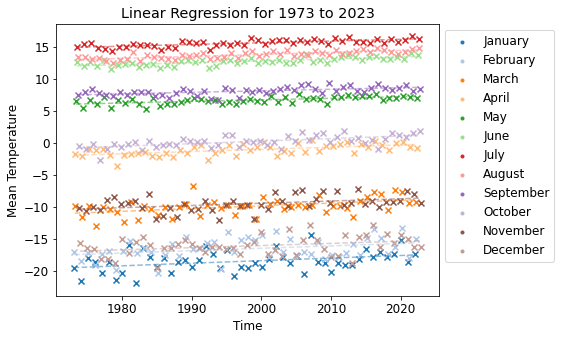

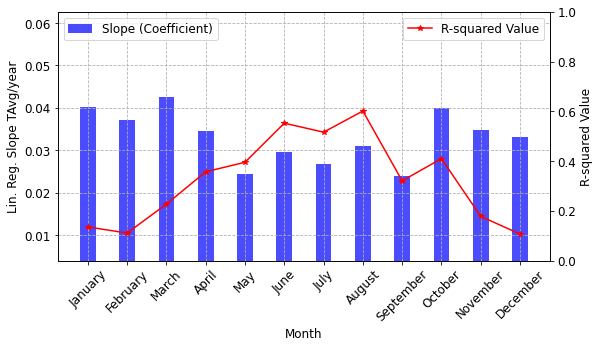

In [208]:


# Create lists to store legend handles
legend_handles = []

# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1973-01-01')
enddate = pd.to_datetime('2023-01-01')

for i in range(1, 13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_TAvg_dict[i]['time'] >= startdate) & (monthly_mean_TAvg_dict[i]['time'] <= enddate)
    
    x = np.arange(len(monthly_mean_TAvg_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_TAvg_dict[i][mask]

    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    plt.scatter(monthly_mean_TAvg_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    plt.plot(monthly_mean_TAvg_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--', alpha  = 0.5)

    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.', color=color))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend outside the plot
plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))

# Adjust the plot layout to accommodate the legend
plt.subplots_adjust(right=0.75)

plt.show()

# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')


slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Create x-values for the bars
x = np.arange(len(slopes))

# Plot the slopes as bars on the primary y-axis
ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Lin. Reg. Slope TAvg/year')
ax1.set_ylim(min(slopes) - 0.02, max(slopes) + 0.02)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
ax1.grid(ls = '--')
ax1.legend(loc='upper left')

# Create a secondary y-axis for R-squared values on the right
ax2 = ax1.twinx()
ax2.plot(x, r_squared_values, 'r*-', label='R-squared Value')
ax2.set_ylabel('R-squared Value')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

# plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
plt.tight_layout()

#plt.savefig('TMean_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.png', dpi = 300)
plt.show()


## TMin TMax

In [209]:
#monthly_mean_TMax_dict

C:\Users\leonh\AppData\Local\Temp\ipykernel_5592\3467071831.py:77: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r*-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')


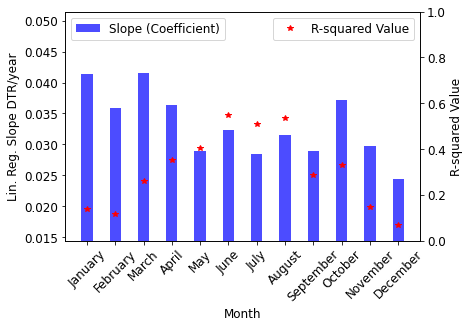

In [210]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 

for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_TMax_dict[i]['time'] >= startdate) & (monthly_mean_TMax_dict[i]['time'] <= enddate)
    
    x = np.arange(len(monthly_mean_TMax_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_TMax_dict[i][mask]

    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    #plt.scatter(monthly_mean_TMax_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    #plt.plot(monthly_mean_TMax_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

    # Create a dummy scatter plot with no markers to represent the legend
    #legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend
# plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# plt.xlabel('Time')
# plt.ylabel('DTR Value')
# plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.show()



# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')

slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes))

slopes_TMax = slopes.copy()
# Plot the slopes as bars on the primary y-axis
ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Lin. Reg. Slope DTR/year')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
ax1.legend(loc='upper left')

# Create a secondary y-axis for R-squared values on the right
ax2 = ax1.twinx()
ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
ax2.set_ylabel('R-squared Value')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

# Show the plot
# plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
plt.tight_layout()

#plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
plt.show()


In [211]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 

for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_TMin_dict[i]['time'] >= startdate) & (monthly_mean_TMin_dict[i]['time'] <= enddate)
    
    x = np.arange(len(monthly_mean_TMin_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_TMin_dict[i][mask]

    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    #plt.scatter(monthly_mean_TMax_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    #plt.plot(monthly_mean_TMax_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

    # Create a dummy scatter plot with no markers to represent the legend
    #legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend
# plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# plt.xlabel('Time')
# plt.ylabel('DTR Value')
# plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.show()



# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')

slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# # Create a figure and a set of subplots
# fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes))

slopes_TMin = slopes.copy()
# # Plot the slopes as bars on the primary y-axis
# ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Lin. Reg. Slope DTR/year')
# ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# # Rotate the x-axis tick labels
# ax1.set_xticks(x)
# ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
# ax1.legend(loc='upper left')

# # Create a secondary y-axis for R-squared values on the right
# ax2 = ax1.twinx()
# ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# ax2.set_ylabel('R-squared Value')
# ax2.set_ylim(0, 1)
# ax2.legend(loc='upper right')

# # Show the plot
# # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.tight_layout()

# plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# plt.show()


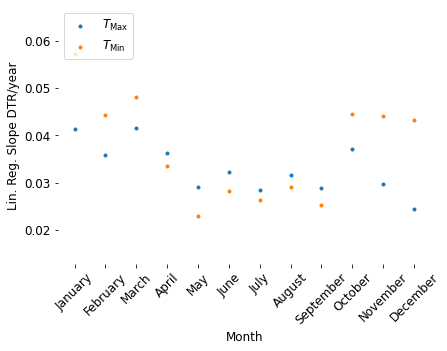

In [212]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes_TMax))


# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='.', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.', label='$T_{\mathrm{Min}}$')


ax1.set_xlabel('Month')
ax1.set_ylabel('Lin. Reg. Slope DTR/year')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
ax1.legend(loc='upper left')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


# # Create a secondary y-axis for R-squared values on the right
# ax2 = ax1.twinx()
# ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# ax2.set_ylabel('R-squared Value')
# ax2.set_ylim(0, 1)
# ax2.legend(loc='upper right')

# # Show the plot
# # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.tight_layout()

# plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# plt.show()

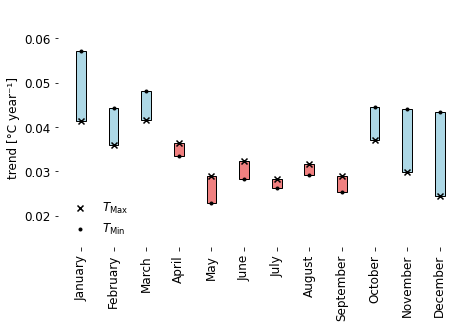

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code here

# Calculate the width of the boxes
box_width = 0.3  # Adjust this value to control the width of the boxes

fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# for i in range(len(slopes_TMax)):
#     ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor='lightgray'))
for i in range(len(slopes_TMax)):
    if slopes_TMin[i] > slopes_TMax[i]:
        facecolor = 'lightblue'
    else:
        facecolor = 'lightcoral'
    
    ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor=facecolor))


# Create x-values for the bars
x = np.arange(len(slopes_TMax))


# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='x',color = 'black', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.',color = 'black', label='$T_{\mathrm{Min}}$')

ax1.set_ylabel('trend [°C year\u207B\u00B9]')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=90)  # Rotate the labels here
ax1.legend(loc=3,frameon = False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('Monthly_Trends19722022_NorthernHem_40_70_noPValue.pdf')
# Show the plot
plt.show()



## Bootstrapping


In [214]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

df_significance1973 = pd.DataFrame(columns= ['Month', 'Slope', 'PValue'])

startdate = pd.to_datetime('1973-01-01')
enddate = pd.to_datetime('2023-01-01') 


for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

    x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_DTR_dict[i][mask]


    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000  # You can adjust this number

    # Initialize an array to store the bootstrapped parameter estimates
    bootstrapped_coefs = np.zeros(n_bootstrap_samples)

    observed_coef = np.polyfit(x, y, 1)[0]
    # Perform bootstrapping
    for j in range(n_bootstrap_samples):
        # Resample with replacement from the data
        resampled_indices = np.random.choice(len(y), len(y), replace=True)
        resampled_y = y[resampled_indices]
        
        # Compute the parameter of interest (in this case, the coefficient of the linear regression)
        coef = np.polyfit(x, resampled_y, 1)[0]
        
        # Store the bootstrapped coefficient
        bootstrapped_coefs[j] = coef

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrapped_coefs, [10, 90])

    # Print the confidence interval
    #print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

    p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

    data_dict = {
        'Month': i,
        'Slope': observed_coef,
        'PValue': p_value  # Initialize PValue, you'll calculate it later
    }
    data_df = pd.DataFrame(data_dict, index=[0])
    # Append the dictionary to the DataFrame
    df_significance1973 = pd.concat([df_significance1973, data_df], ignore_index=True)
    # Print the p-value
    print("Bootstrapped p-value:", p_value)

Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.005
Bootstrapped p-value: 0.057
Bootstrapped p-value: 0.288
Bootstrapped p-value: 0.014
Bootstrapped p-value: 0.06
Bootstrapped p-value: 0.184
Bootstrapped p-value: 0.12
Bootstrapped p-value: 0.465
Bootstrapped p-value: 0.015
Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.0


In [215]:
print(df_significance1973)

   Month     Slope  PValue
0      1 -0.014576   0.000
1      2 -0.008352   0.005
2      3 -0.005807   0.057
3      4  0.003024   0.288
4      5  0.006519   0.014
5      6  0.004339   0.060
6      7  0.002861   0.184
7      8  0.003363   0.120
8      9  0.002958   0.465
9     10 -0.007586   0.015
10    11 -0.014227   0.000
11    12 -0.018777   0.000


In [216]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

df_significance1972 = pd.DataFrame(columns= ['Month', 'Slope', 'PValue'])

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 


for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

    x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
    y = monthly_mean_DTR_dict[i][mask]


    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000  # You can adjust this number

    # Initialize an array to store the bootstrapped parameter estimates
    bootstrapped_coefs = np.zeros(n_bootstrap_samples)

    observed_coef = np.polyfit(x, y, 1)[0]
    # Perform bootstrapping
    for j in range(n_bootstrap_samples):
        # Resample with replacement from the data
        resampled_indices = np.random.choice(len(y), len(y), replace=True)
        resampled_y = y[resampled_indices]
        
        # Compute the parameter of interest (in this case, the coefficient of the linear regression)
        coef = np.polyfit(x, resampled_y, 1)[0]
        
        # Store the bootstrapped coefficient
        bootstrapped_coefs[j] = coef

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrapped_coefs, [10, 90])

    # Print the confidence interval
    #print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

    p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

    data_dict = {
        'Month': i,
        'Slope': observed_coef,
        'PValue': p_value  # Initialize PValue, you'll calculate it later
    }
    data_df = pd.DataFrame(data_dict, index=[0])
    # Append the dictionary to the DataFrame
    df_significance1972 = pd.concat([df_significance1972, data_df], ignore_index=True)
    # Print the p-value
    print("Bootstrapped p-value:", p_value)

Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.003
Bootstrapped p-value: 0.042
Bootstrapped p-value: 0.291
Bootstrapped p-value: 0.018
Bootstrapped p-value: 0.061
Bootstrapped p-value: 0.292
Bootstrapped p-value: 0.231
Bootstrapped p-value: 0.329
Bootstrapped p-value: 0.018
Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.0


In [217]:
df_significance1972

,Month,Slope,PValue
0,1,-0.015740,0.000
1,2,-0.008327,0.003
2,3,-0.006571,0.042
3,4,0.002762,0.291
4,5,0.006159,0.018
5,6,0.004028,0.061
6,7,0.002091,0.292
7,8,0.002453,0.231
8,9,0.003619,0.329
9,10,-0.007439,0.018


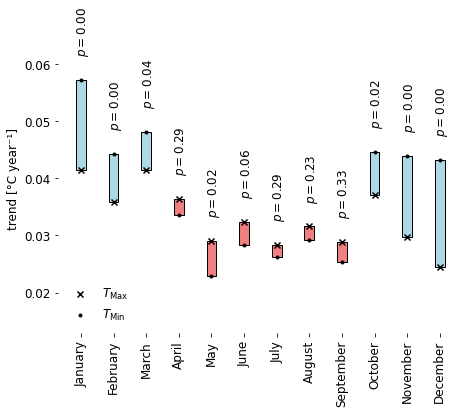

In [218]:

# Create x-values for the bars
x = np.arange(len(slopes_TMax))

# Calculate the width of the boxes
box_width = 0.3  # Adjust this value to control the width of the boxes

fig, ax1 = plt.subplots(figsize = (17/ 2.54, 15/ 2.54))

# for i in range(len(slopes_TMax)):
#     ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor='lightgray'))
for i in range(len(slopes_TMax)):
    if slopes_TMin[i] > slopes_TMax[i]:
        facecolor = 'lightblue'
    else:
        facecolor = 'lightcoral'
    
    ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor=facecolor))




# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='x',color = 'black', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.',color = 'black', label='$T_{\mathrm{Min}}$')

for i in range(0,12):
   ax1.text(i - 0.17, np.max([slopes_TMax[i], slopes_TMin[i]]) + 0.005, r'$p = {:.2f}$'.format(df_significance1972['PValue'][i]), rotation=90)


ax1.set_ylabel('trend [°C year\u207B\u00B9]')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=90)  # Rotate the labels here
ax1.legend(loc=3,frameon = False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('Monthly_Trends19722022_NorthernHem_40_70_PValue.pdf')
# Show the plot
plt.show()

### Trend June & July combined

In [219]:
startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01')

# Define a function to filter and concatenate xarrays
def filter_and_concat(xarray_dict, startdate, enddate):
    filtered_xarrays = []

    for key, xarray_data in xarray_dict.items():
        mask = (xarray_data['time'] >= startdate) & (xarray_data['time'] <= enddate)
        filtered_xarray = xarray_data.where(mask, drop=True)
        filtered_xarrays.append(filtered_xarray)

    concatenated_xarray = xr.concat(filtered_xarrays, dim='time')
    return concatenated_xarray

# Concatenate xarrays for the specified keys (e.g., 6 and 7)
keys_to_concatenate = [4, 5, 6, 7,8, 9]
df_JuneJuly = filter_and_concat({key: monthly_mean_DTR_dict[key] for key in keys_to_concatenate}, startdate, enddate)

# print(df_JuneJuly)
# df_JuneJuly.name = 'DTR'
df_JuneJuly = df_JuneJuly.rename('DTR')

#print(df_JuneJuly)

# # Sort the data by the time dimension
df_JuneJuly_sorted = df_JuneJuly.sortby('time')

# # Resample to yearly frequency (365 days per year)
df_JuneJuly_resampled = df_JuneJuly_sorted.resample(time='Y').mean()

# # Convert the resampled data to a Pandas DataFrame
df_JuneJuly_resampled = df_JuneJuly_resampled.to_dataframe()

#print(df_JuneJuly_resampled.iloc[:, 0].index)
# # Assign a name to the resulting DataFrame
# df_JuneJuly_resampled.name = 'YourNameHere'

x = np.arange(len(df_JuneJuly_resampled))  # Use an index as x values
y = df_JuneJuly_resampled['DTR']


# Define the number of bootstrap samples
n_bootstrap_samples = 10000  # You can adjust this number

# Initialize an array to store the bootstrapped parameter estimates
bootstrapped_coefs = np.zeros(n_bootstrap_samples)

observed_coef = np.polyfit(x, y, 1)[0]
# Perform bootstrapping
for j in range(n_bootstrap_samples):
    # Resample with replacement from the data
    resampled_indices = np.random.choice(len(y), len(y), replace=True)
    resampled_y = y[resampled_indices]
    
    # Compute the parameter of interest (in this case, the coefficient of the linear regression)
    coef = np.polyfit(x, resampled_y, 1)[0]
    
    # Store the bootstrapped coefficient
    bootstrapped_coefs[j] = coef

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrapped_coefs, [5, 95])

# Print the confidence interval
print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

data_dict = {
    'Month': i,
    'Slope': observed_coef,
    'PValue': p_value  # Initialize PValue, you'll calculate it later
}
data_df = pd.DataFrame(data_dict, index=[0])
# Append the dictionary to the DataFrame
df_significance1973 = pd.concat([df_significance1973, data_df], ignore_index=True)
# Print the p-value
print("Bootstrapped p-value:", p_value)

Bootstrap Confidence Interval for Coefficient: [-0.00240852  0.00241308]
Bootstrapped p-value: 0.018


In [220]:
df_significance1973

,Month,Slope,PValue
0,1,-0.014576,0.000
1,2,-0.008352,0.005
2,3,-0.005807,0.057
3,4,0.003024,0.288
4,5,0.006519,0.014
5,6,0.004339,0.060
6,7,0.002861,0.184
7,8,0.003363,0.120
8,9,0.002958,0.465
9,10,-0.007586,0.015


In [221]:

# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# df_significance1973 = pd.DataFrame(columns=['Month', 'Slope', 'PValue'])

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01')

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

#     x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
#     y = monthly_mean_DTR_dict[i][mask]

#     # Fit a linear regression line
#     slope, intercept = np.polyfit(x, y, 1)

#     # Calculate R-squared
#     residuals = y - (slope * x + intercept)
#     ss_res = np.sum(residuals**2)
#     ss_tot = np.sum((y - np.mean(y))**2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # Create a dictionary to store the data for the current iteration
#     data_dict = {
#         'Month': i,
#         'Slope': slope,
#         'PValue': None  # Initialize PValue, you'll calculate it later
#     }

#     # Append the dictionary to the DataFrame
#     df_significance1973 = df_significance1973.append(data_dict, ignore_index=True)

#     # ... Rest of your code for plotting and bootstrapping

#     # Calculate and update the p-value in the DataFrame
#     p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()
#     df_significance1973.at[i - 1, 'PValue'] = p_value

# # After the loop, df_significance1973 will contain the desired data
# print(df_significance1973)


In [222]:
print(np.abs(observed_coef))
print(np.abs(bootstrapped_coefs))
print((np.abs(bootstrapped_coefs) >= np.abs(observed_coef)))
bootstrapped_coefs

0.003518614400834545
[0.00042504 0.00022212 0.00132836 ... 0.0015381  0.00042818 0.00175567]
[False False False ... False False False]


array([ 0.00042504, -0.00022212,  0.00132836, ..., -0.0015381 ,
        0.00042818, -0.00175567])